# Домашнее задание 1

В этом домашнем задании вам предстоит применить инструменты временного анализа на реальных климатических данных. На примере температур по выбранной стране вы отработаете ключевые элементы пайплайна прогнозирования: подготовку временного ряда, корректное разбиение на обучающую и тестовую части, использование скользящего окна, генерацию признаков и обучение простой модели.

Результатом станет ноутбук с кодом, графиками и краткими пояснениями, в котором вы продемонстрируете умение строить базовый прогноз временного ряда и оценивать его качество с помощью метрик.

Датасет: "Climate Change: Earth Surface Temperature Data"

В этом задании вы примените знания из третьего модуля к реальным климатическим данным.

Подготовка данных.

Загрузите датасет GlobalLandTemperaturesByCountry.csv.

Выберите одну страну (например, Belarus или любую другую) и постройте временной ряд средних месячных температур. Убедитесь, что индекс данных — это дата.

Holdout-разбиение.

Разделите временной ряд: первые 80% наблюдений оставьте для обучения, оставшиеся 20% — для теста.

Визуализируйте train/test на одном графике.

Скользящее окно.

Реализуйте rolling-window-разбиение: обучающие отрезки длиной 120 месяцев (10 лет) и прогнозный горизонт 12 месяцев. Визуализируйте хотя бы первые два сплита.

Генерация признаков.

Для временного ряда создайте лаги (например, на 1 и 12 месяцев) и календарные признаки: номер месяца и индикатор зимнего сезона (декабрь — февраль).

Покажите первые строки получившегося датафрейма.

Оценка прогноза.

Постройте простую модель (например, линейную регрессию, где целевая переменная — температура, а признаки — лаги и дата-фичи).

Сделайте прогноз на тестовой выборке из holdout-разбиения.

Посчитайте метрики MAE, RMSE и MAPE.

## Шаг 1. Знакомство с данными

### Этап 1.1 Датасет

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')

In [4]:
print("Первые 5 строк исходного датасета:")
df.head()

Первые 5 строк исходного датасета:


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
print("\nИнформация о датасете:")
df.info()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [6]:
selected_country = 'Russia'

# Фильтрация данных по выбранной стране
country_df = df[df['Country'] == selected_country].copy()
print(f"\nРазмер датафрейма для страны {selected_country}: {country_df.shape}")


Размер датафрейма для страны Russia: (2421, 4)


### Этап 1.2 Преобразования

In [7]:
country_df['dt'] = pd.to_datetime(country_df['dt'])
country_df.set_index('dt', inplace=True)
country_df.sort_index(inplace=True)

In [8]:
# Проверка пропусков в столбце AverageTemperature
print(f"Количество пропусков в температуре: {country_df['AverageTemperature'].isnull().sum()}")
print(f"Общее количество записей: {len(country_df)}")
print(f"Процент пропусков: {country_df['AverageTemperature'].isnull().sum() / len(country_df) * 100:.2f}%")

Количество пропусков в температуре: 16
Общее количество записей: 2421
Процент пропусков: 0.66%


In [9]:
# Проверка частоты временного ряда
print("\nПервые несколько дат в индексе:")
print(country_df.index[:10])
print("\nПоследние несколько дат в индексе:")
print(country_df.index[-10:])


Первые несколько дат в индексе:
DatetimeIndex(['1812-01-01', '1812-02-01', '1812-03-01', '1812-04-01',
               '1812-05-01', '1812-06-01', '1812-07-01', '1812-08-01',
               '1812-09-01', '1812-10-01'],
              dtype='datetime64[ns]', name='dt', freq=None)

Последние несколько дат в индексе:
DatetimeIndex(['2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='dt', freq=None)


In [10]:
# Проверка регулярности частоты
date_diff = country_df.index.to_series().diff()
print(f"\nТипичный интервал между измерениями: {date_diff.mode().iloc[0]}")


Типичный интервал между измерениями: 31 days 00:00:00


In [11]:
# Интерполяция
initial_count = len(country_df)
country_df['AverageTemperature'] = country_df['AverageTemperature'].interpolate(method='time')
remaining_na = country_df['AverageTemperature'].isnull().sum()
print(f"Пропуски после интерполяции: {remaining_na}")

if remaining_na > 0:
    country_df['AverageTemperature'] = country_df['AverageTemperature'].fillna(method='bfill').fillna(method='ffill')
    print(f"Пропуски после полного заполнения: {country_df['AverageTemperature'].isnull().sum()}")

country_df = country_df.asfreq('MS')
print(f"Размер датафрейма после установки частоты: {len(country_df)}")

Пропуски после интерполяции: 0
Размер датафрейма после установки частоты: 2421


### Этап 1.3 Визуализация

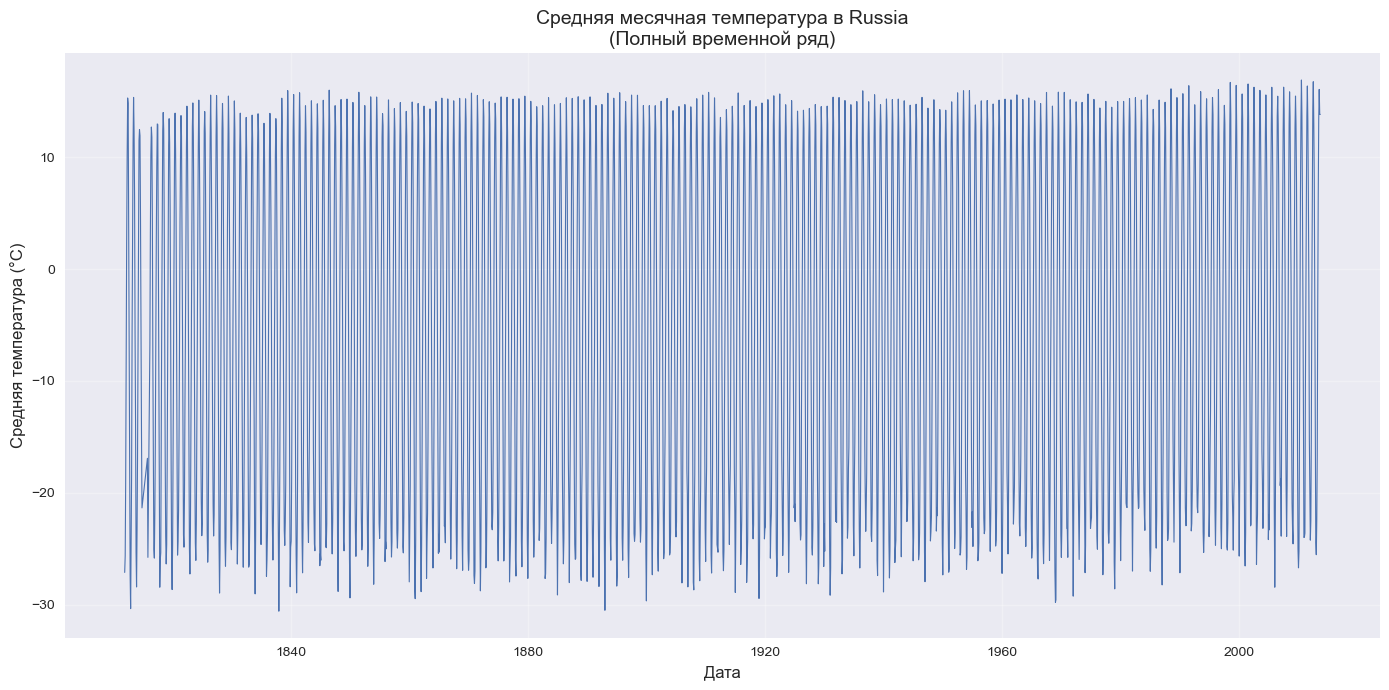

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(country_df.index, country_df['AverageTemperature'], linewidth=0.8)
plt.title(f'Средняя месячная температура в {selected_country}\n(Полный временной ряд)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средняя температура (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Описательная статистика температур:
count    2421.000000
mean       -5.579679
std        14.557329
min       -30.577000
25%       -19.327000
50%        -5.270000
75%         7.769000
max        16.893000
Name: AverageTemperature, dtype: float64


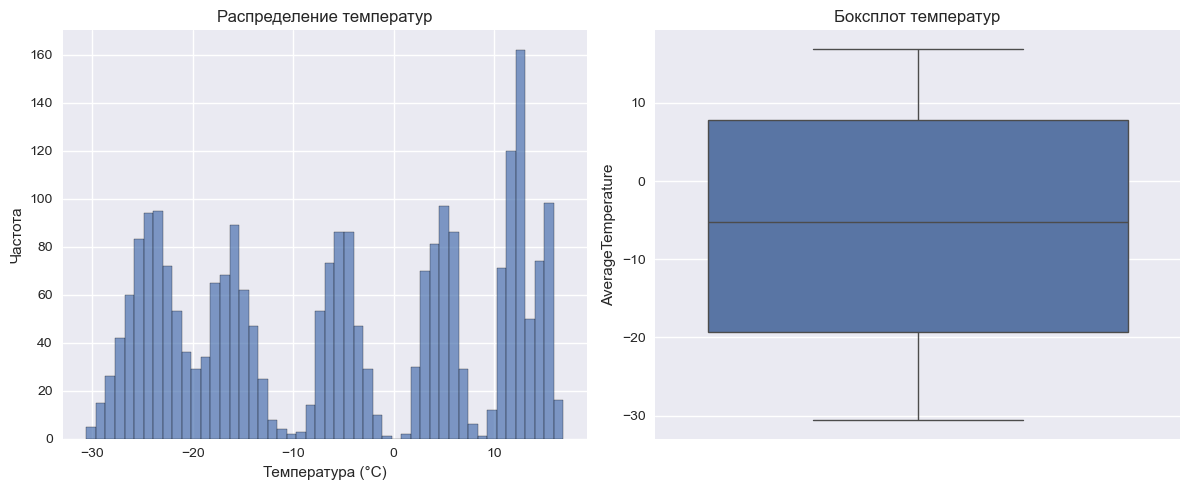

In [13]:
print("Описательная статистика температур:")
print(country_df['AverageTemperature'].describe())

# Визуализация распределения температур
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(country_df['AverageTemperature'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение температур')
plt.xlabel('Температура (°C)')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(y=country_df['AverageTemperature'])
plt.title('Боксплот температур')

plt.tight_layout()
plt.show()

## Шаг 2. Holdout-разбиение

### Этап 2.1. деление 80% train / 20% test

In [14]:
total_length = len(country_df)
split_index = int(total_length * 0.8)

print(f"Общее количество наблюдений: {total_length}")
print(f"Индекс разделения: {split_index}")
print(f"Размер обучающей выборки: {split_index} ({split_index/total_length*100:.1f}%)")
print(f"Размер тестовой выборки: {total_length - split_index} ({(total_length-split_index)/total_length*100:.1f}%)")

Общее количество наблюдений: 2421
Индекс разделения: 1936
Размер обучающей выборки: 1936 (80.0%)
Размер тестовой выборки: 485 (20.0%)


In [15]:
train_data = country_df.iloc[:split_index]
test_data = country_df.iloc[split_index:]

print(f"\nПериод обучающей выборки: {train_data.index[0]} - {train_data.index[-1]}")
print(f"Период тестовой выборки: {test_data.index[0]} - {test_data.index[-1]}")


Период обучающей выборки: 1812-01-01 00:00:00 - 1973-04-01 00:00:00
Период тестовой выборки: 1973-05-01 00:00:00 - 2013-09-01 00:00:00


In [17]:
print("Статистика по обучающей выборке:")
print(f"- Период: {train_data.index[0].strftime('%Y-%m')} - {train_data.index[-1].strftime('%Y-%m')}")
print(f"- Количество наблюдений: {len(train_data)}")
print(f"- Средняя температура: {train_data['AverageTemperature'].mean():.2f}°C")
print(f"- Диапазон температур: {train_data['AverageTemperature'].min():.2f}°C - {train_data['AverageTemperature'].max():.2f}°C")

Статистика по обучающей выборке:
- Период: 1812-01 - 1973-04
- Количество наблюдений: 1936
- Средняя температура: -5.87°C
- Диапазон температур: -30.58°C - 15.99°C


In [18]:
print("\nСтатистика по тестовой выборке:")
print(f"- Период: {test_data.index[0].strftime('%Y-%m')} - {test_data.index[-1].strftime('%Y-%m')}")
print(f"- Количество наблюдений: {len(test_data)}")
print(f"- Средняя температура: {test_data['AverageTemperature'].mean():.2f}°C")
print(f"- Диапазон температур: {test_data['AverageTemperature'].min():.2f}°C - {test_data['AverageTemperature'].max():.2f}°C")


Статистика по тестовой выборке:
- Период: 1973-05 - 2013-09
- Количество наблюдений: 485
- Средняя температура: -4.42°C
- Диапазон температур: -28.58°C - 16.89°C


Глобальное потепление :(

### Этап 2.2 Визуализация

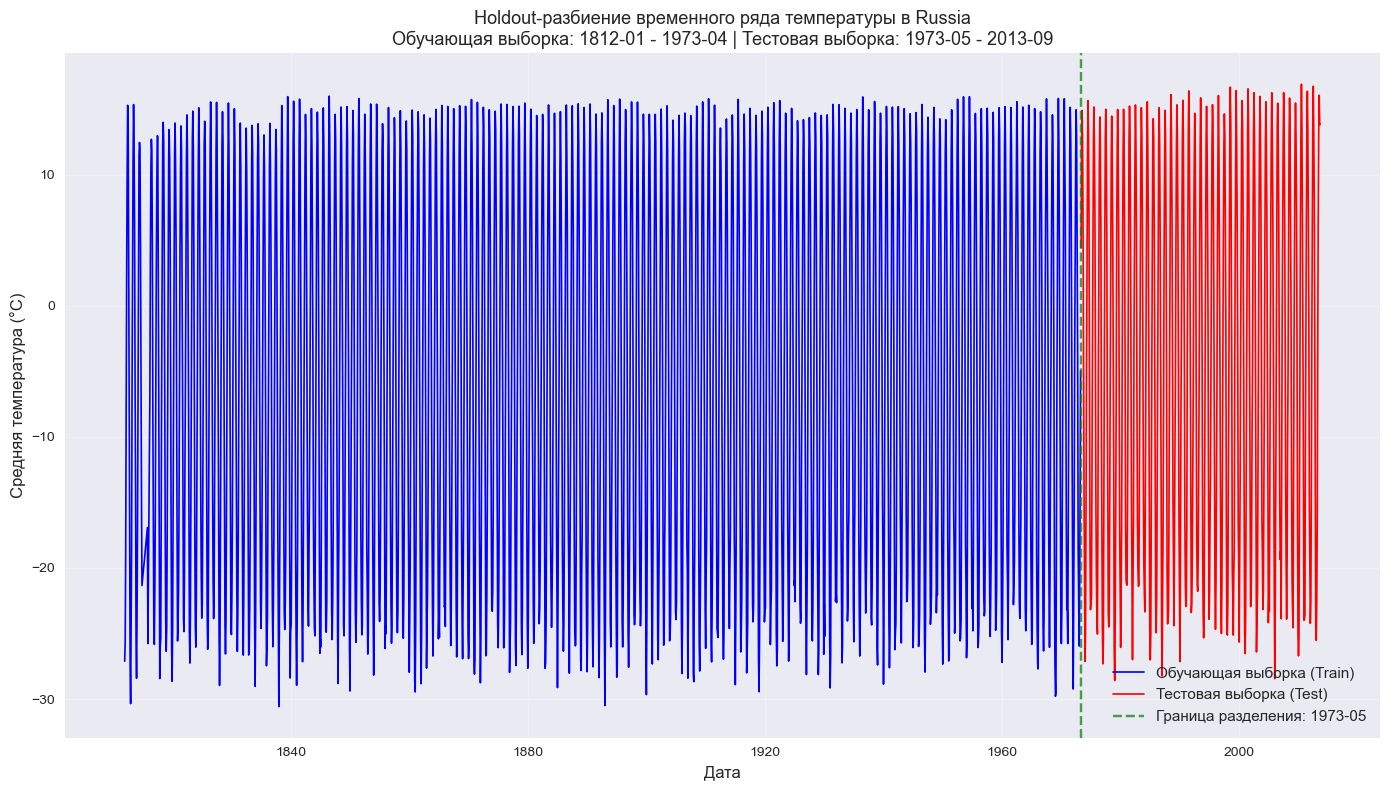

In [16]:
plt.figure(figsize=(14, 8))

# Обучающая выборка
plt.plot(train_data.index, train_data['AverageTemperature'], 
         color='blue', linewidth=1.2, label='Обучающая выборка (Train)')

# Тестовая выборка
plt.plot(test_data.index, test_data['AverageTemperature'], 
         color='red', linewidth=1.2, label='Тестовая выборка (Test)')

# Вертикальная линия, показывающая место разделения
plt.axvline(x=test_data.index[0], color='green', linestyle='--', 
            alpha=0.7, label=f'Граница разделения: {test_data.index[0].strftime("%Y-%m")}')

plt.title(f'Holdout-разбиение временного ряда температуры в {selected_country}\n'
          f'Обучающая выборка: {train_data.index[0].strftime("%Y-%m")} - {train_data.index[-1].strftime("%Y-%m")} | '
          f'Тестовая выборка: {test_data.index[0].strftime("%Y-%m")} - {test_data.index[-1].strftime("%Y-%m")}', 
          fontsize=13)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средняя температура (°C)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Шаг 3. Rolling window (backtesting)

### Этап 3.1 Реализация скользящего окна

In [19]:
# Параметры скользящего окна
window_size = 120  # 10 лет для обучения
horizon = 12       # 1 год для прогноза

In [20]:
# Создадим функцию для генерации сплитов скользящего окна
def generate_rolling_windows(data, window_size, horizon):
    splits = []
    total_length = len(data)
    
    # Начинаем с индекса, где первый тестовый набор не выходит за границы данных
    start_index = 0
    end_index = start_index + window_size + horizon
    
    while end_index <= total_length:
        train_indices = data.index[start_index:start_index + window_size]
        test_indices = data.index[start_index + window_size:end_index]
        splits.append((train_indices, test_indices))
        start_index += 1
        end_index = start_index + window_size + horizon
    
    return splits

In [21]:
# Сплиты
splits = generate_rolling_windows(country_df, window_size, horizon)
print(f"Всего сплитов скользящего окна: {len(splits)}")
print(f"Размер окна обучения: {window_size} месяцев ({window_size/12:.1f} лет)")
print(f"Горизонт прогноза: {horizon} месяцев ({horizon/12:.1f} лет)")

Всего сплитов скользящего окна: 2290
Размер окна обучения: 120 месяцев (10.0 лет)
Горизонт прогноза: 12 месяцев (1.0 лет)


In [22]:
# Инфо о 2-х сплитах
for i, (train_idx, test_idx) in enumerate(splits[:2]):
    print(f"\nСплит #{i+1}:")
    print(f"  Обучающая выборка: {len(train_idx)} месяцев, период: {train_idx[0].strftime('%Y-%m')} - {train_idx[-1].strftime('%Y-%m')}")
    print(f"  Тестовая выборка:  {len(test_idx)} месяцев, период: {test_idx[0].strftime('%Y-%m')} - {test_idx[-1].strftime('%Y-%m')}")


Сплит #1:
  Обучающая выборка: 120 месяцев, период: 1812-01 - 1821-12
  Тестовая выборка:  12 месяцев, период: 1822-01 - 1822-12

Сплит #2:
  Обучающая выборка: 120 месяцев, период: 1812-02 - 1822-01
  Тестовая выборка:  12 месяцев, период: 1822-02 - 1823-01


### Этап 3.2 Визуализация

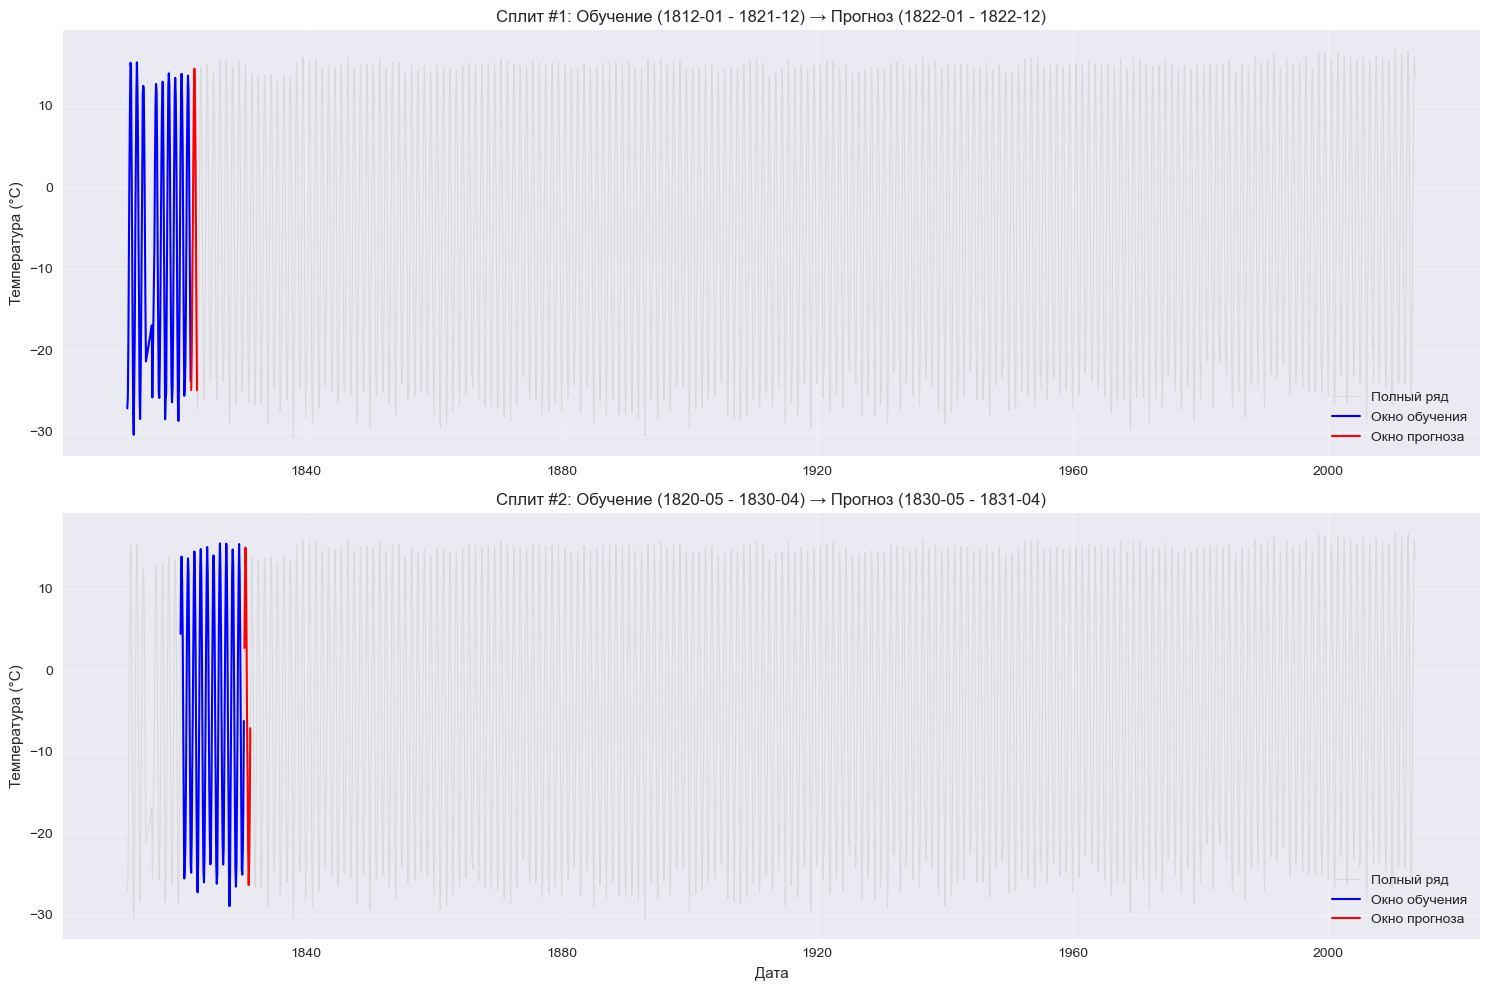

In [26]:
# Визуализация сплитов
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 1 сплит
train_idx_1, test_idx_1 = splits[0]
axes[0].plot(country_df.index, country_df['AverageTemperature'], 
             color='lightgray', linewidth=0.8, label='Полный ряд', alpha=0.7)
axes[0].plot(train_idx_1, country_df.loc[train_idx_1, 'AverageTemperature'], 
             color='blue', linewidth=1.5, label='Окно обучения')
axes[0].plot(test_idx_1, country_df.loc[test_idx_1, 'AverageTemperature'], 
             color='red', linewidth=1.5, label='Окно прогноза')
axes[0].set_title(f'Сплит #1: Обучение ({train_idx_1[0].strftime("%Y-%m")} - {train_idx_1[-1].strftime("%Y-%m")}) → '
                  f'Прогноз ({test_idx_1[0].strftime("%Y-%m")} - {test_idx_1[-1].strftime("%Y-%m")})', fontsize=12)
axes[0].set_ylabel('Температура (°C)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 100 сплит (для наглядности)
train_idx_2, test_idx_2 = splits[100]
axes[1].plot(country_df.index, country_df['AverageTemperature'], 
             color='lightgray', linewidth=0.8, label='Полный ряд', alpha=0.7)
axes[1].plot(train_idx_2, country_df.loc[train_idx_2, 'AverageTemperature'], 
             color='blue', linewidth=1.5, label='Окно обучения')
axes[1].plot(test_idx_2, country_df.loc[test_idx_2, 'AverageTemperature'], 
             color='red', linewidth=1.5, label='Окно прогноза')
axes[1].set_title(f'Сплит #2: Обучение ({train_idx_2[0].strftime("%Y-%m")} - {train_idx_2[-1].strftime("%Y-%m")}) → '
                  f'Прогноз ({test_idx_2[0].strftime("%Y-%m")} - {test_idx_2[-1].strftime("%Y-%m")})', fontsize=12)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].set_ylabel('Температура (°C)', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

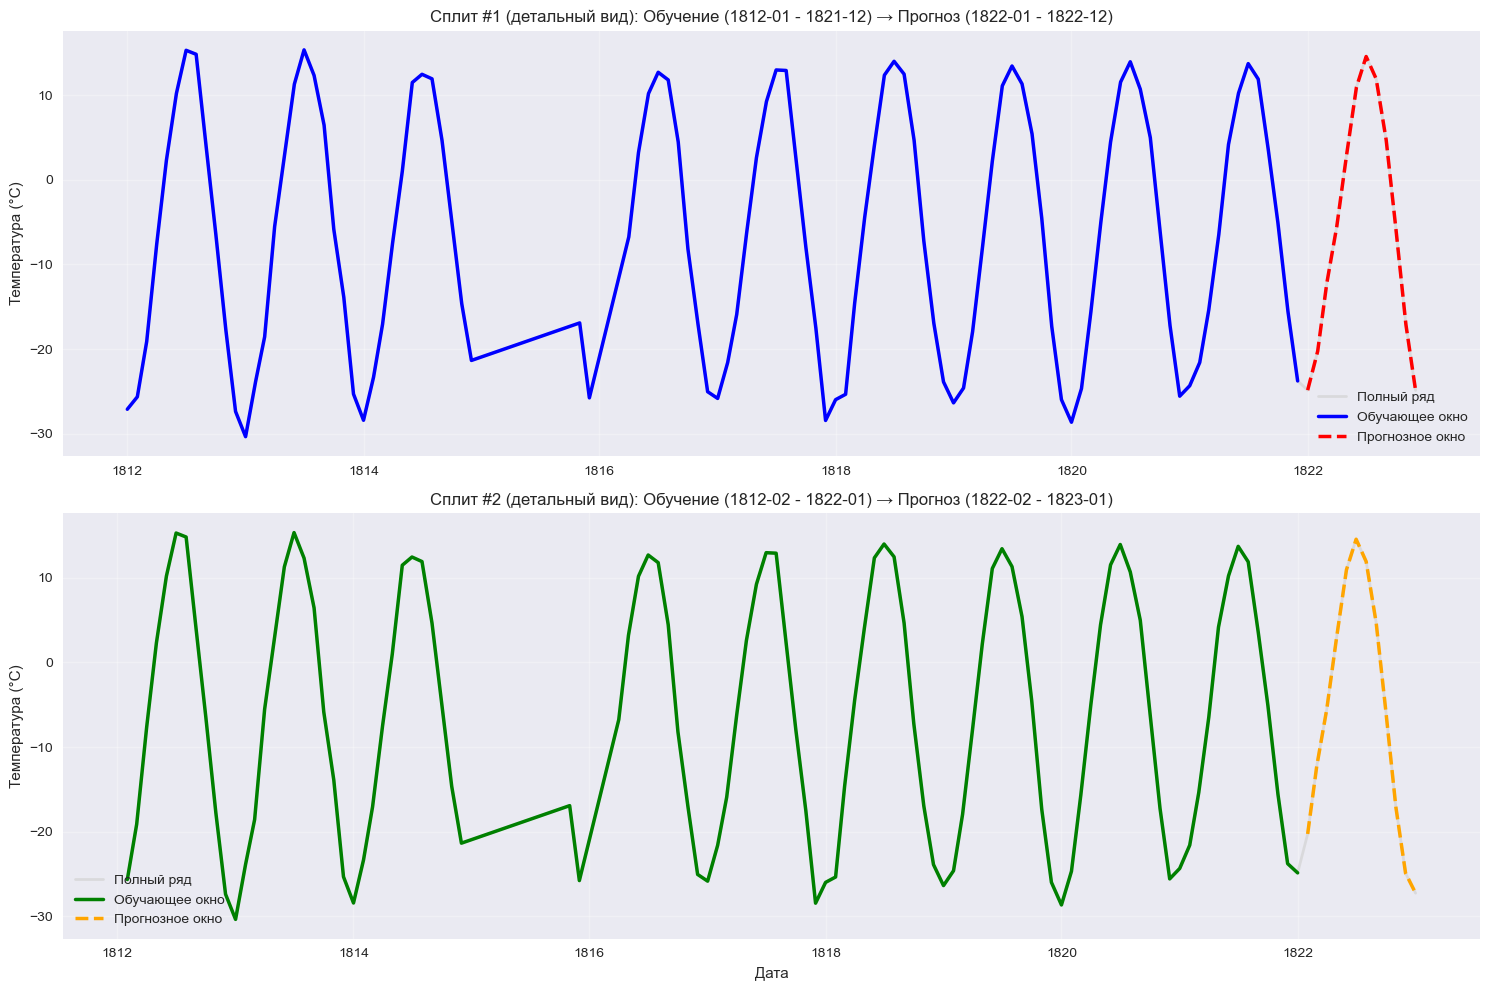

In [38]:
# Дополнительная визуализация: фокус на первых двух сплитах с аннотациями
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Первый сплит - детальный вид
train_idx_1, test_idx_1 = splits[0]
display_start_1 = train_idx_1[0]
display_end_1 = test_idx_1[-1]
mask_1 = (country_df.index >= display_start_1) & (country_df.index <= display_end_1)
display_data_1 = country_df[mask_1]

ax1.plot(display_data_1.index, display_data_1['AverageTemperature'], 
         color='lightgray', linewidth=2, alpha=0.7, label='Полный ряд')
ax1.plot(train_idx_1, country_df.loc[train_idx_1, 'AverageTemperature'], 
         color='blue', linewidth=2.5, label='Обучающее окно')
ax1.plot(test_idx_1, country_df.loc[test_idx_1, 'AverageTemperature'], 
         color='red', linewidth=2.5, linestyle='--', label='Прогнозное окно')
ax1.set_title(f'Сплит #1 (детальный вид): Обучение ({train_idx_1[0].strftime("%Y-%m")} - {train_idx_1[-1].strftime("%Y-%m")}) → '
              f'Прогноз ({test_idx_1[0].strftime("%Y-%m")} - {test_idx_1[-1].strftime("%Y-%m")})', fontsize=12)
ax1.set_ylabel('Температура (°C)', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Второй сплит - детальный вид
train_idx_2, test_idx_2 = splits[1]
display_start_2 = train_idx_2[0]
display_end_2 = test_idx_2[-1]
mask_2 = (country_df.index >= display_start_2) & (country_df.index <= display_end_2)
display_data_2 = country_df[mask_2]

ax2.plot(display_data_2.index, display_data_2['AverageTemperature'], 
         color='lightgray', linewidth=2, alpha=0.7, label='Полный ряд')
ax2.plot(train_idx_2, country_df.loc[train_idx_2, 'AverageTemperature'], 
         color='green', linewidth=2.5, label='Обучающее окно')
ax2.plot(test_idx_2, country_df.loc[test_idx_2, 'AverageTemperature'], 
         color='orange', linewidth=2.5, linestyle='--', label='Прогнозное окно')
ax2.set_title(f'Сплит #2 (детальный вид): Обучение ({train_idx_2[0].strftime("%Y-%m")} - {train_idx_2[-1].strftime("%Y-%m")}) → '
              f'Прогноз ({test_idx_2[0].strftime("%Y-%m")} - {test_idx_2[-1].strftime("%Y-%m")})', fontsize=12)
ax2.set_xlabel('Дата', fontsize=11)
ax2.set_ylabel('Температура (°C)', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
print("Анализ покрытия данных скользящим окном:")
print(f"Период исходных данных: {country_df.index[0].strftime('%Y-%m')} - {country_df.index[-1].strftime('%Y-%m')}")
print(f"Количество наблюдений: {len(country_df)}")
print(f"Количество сплитов: {len(splits)}")
print(f"Первый сплит охватывает: {splits[0][0][0].strftime('%Y-%m')} - {splits[0][1][-1].strftime('%Y-%m')}")
print(f"Последний сплит охватывает: {splits[-1][0][0].strftime('%Y-%m')} - {splits[-1][1][-1].strftime('%Y-%m')}")
print(f"Шаг скольжения: 1 месяц")

Анализ покрытия данных скользящим окном:
Период исходных данных: 1812-01 - 2013-09
Количество наблюдений: 2421
Количество сплитов: 2290
Первый сплит охватывает: 1812-01 - 1822-12
Последний сплит охватывает: 2002-10 - 2013-09
Шаг скольжения: 1 месяц


## Шаг 4. Генерация признаков

### Этап 4.1 Создание лагов

In [40]:
features_df = country_df.copy()

# лаги
features_df['temp_lag_1'] = features_df['AverageTemperature'].shift(1)
features_df['temp_lag_12'] = features_df['AverageTemperature'].shift(12)

print("Созданы лаги:")
print("- temp_lag_1: температура за предыдущий месяц")
print("- temp_lag_12: температура за тот же месяц год назад")

Созданы лаги:
- temp_lag_1: температура за предыдущий месяц
- temp_lag_12: температура за тот же месяц год назад


### Этап 4.2 Создание календарных признаков

In [42]:
features_df['month'] = features_df.index.month

features_df['is_winter'] = ((features_df.index.month == 12) | 
                            (features_df.index.month == 1) | 
                            (features_df.index.month == 2)).astype(int)

features_df['is_spring'] = ((features_df.index.month == 3) | 
                            (features_df.index.month == 4) | 
                            (features_df.index.month == 5)).astype(int)

features_df['is_summer'] = ((features_df.index.month == 6) | 
                            (features_df.index.month == 7) | 
                            (features_df.index.month == 8)).astype(int)

features_df['is_fall'] = ((features_df.index.month == 9) | 
                            (features_df.index.month == 10) | 
                            (features_df.index.month == 11)).astype(int)

### Этап 4.3. Вывод первых строк датафрейма с признаками:

In [43]:
features_df_clean = features_df.dropna()

print(f"Размер датафрейма до удаления пропусков: {len(features_df)}")
print(f"Размер датафрейма после удаления пропусков: {len(features_df_clean)}")
print(f"Удалено строк: {len(features_df) - len(features_df_clean)}")
print("\nПервые 10 строк датафрейма с признаками:")
features_df_clean.head(10)

Размер датафрейма до удаления пропусков: 2421
Размер датафрейма после удаления пропусков: 2393
Удалено строк: 28

Первые 10 строк датафрейма с признаками:


,AverageTemperature,AverageTemperatureUncertainty,Country,temp_lag_1,temp_lag_12,month,is_winter,is_spring,is_summer,is_fall
dt,,,,,,,,,,
1813-01-01,-30.351,4.698,Russia,-27.375000,-27.114,1,1,0,0,0
1813-02-01,-23.850,4.498,Russia,-30.351000,-25.644,2,1,0,0,0
1813-03-01,-18.561,5.741,Russia,-23.850000,-19.108,3,0,1,0,0
1813-04-01,-5.516,3.820,Russia,-18.561000,-7.605,4,0,1,0,0
1813-06-01,11.295,3.450,Russia,2.751705,10.200,6,0,0,1,0
1813-07-01,15.339,3.142,Russia,11.295000,15.288,7,0,0,1,0
1813-08-01,12.321,3.069,Russia,15.339000,14.817,8,0,0,1,0
1813-09-01,6.440,3.297,Russia,12.321000,3.909,9,0,0,0,1
1813-10-01,-5.847,3.268,Russia,6.440000,-6.468,10,0,0,0,1


In [44]:
print(features_df_clean.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2393 entries, 1813-01-01 to 2013-08-01
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2393 non-null   float64
 1   AverageTemperatureUncertainty  2393 non-null   float64
 2   Country                        2393 non-null   object 
 3   temp_lag_1                     2393 non-null   float64
 4   temp_lag_12                    2393 non-null   float64
 5   month                          2393 non-null   int32  
 6   is_winter                      2393 non-null   int32  
 7   is_spring                      2393 non-null   int32  
 8   is_summer                      2393 non-null   int32  
 9   is_fall                        2393 non-null   int32  
dtypes: float64(4), int32(5), object(1)
memory usage: 158.9+ KB
None


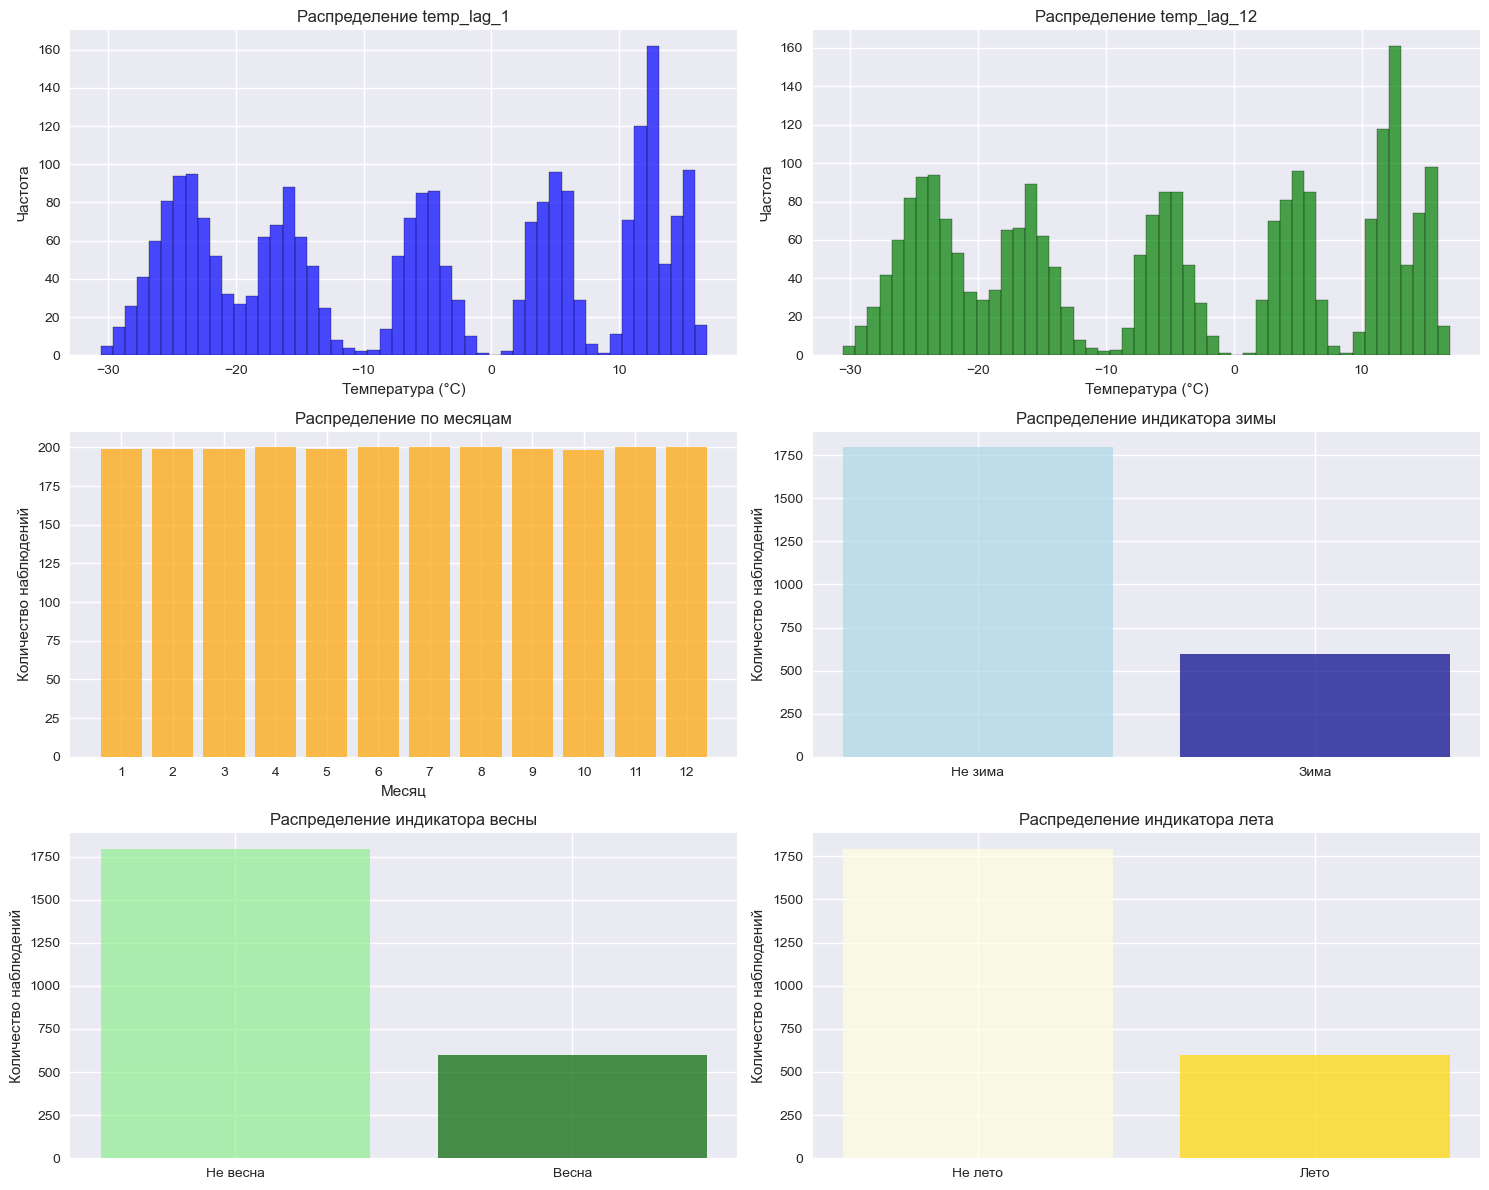

In [53]:
# Визуализируем распределение созданных признаков
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Распределение лага 1
axes[0, 0].hist(features_df_clean['temp_lag_1'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение temp_lag_1')
axes[0, 0].set_xlabel('Температура (°C)')
axes[0, 0].set_ylabel('Частота')

# Распределение лага 12
axes[0, 1].hist(features_df_clean['temp_lag_12'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Распределение temp_lag_12')
axes[0, 1].set_xlabel('Температура (°C)')
axes[0, 1].set_ylabel('Частота')

# Распределение по месяцам
month_counts = features_df_clean['month'].value_counts().sort_index()
axes[1, 0].bar(month_counts.index, month_counts.values, color='orange', alpha=0.7)
axes[1, 0].set_title('Распределение по месяцам')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Количество наблюдений')
axes[1, 0].set_xticks(range(1, 13))

# Распределение зимнего индикатора
winter_counts = features_df_clean['is_winter'].value_counts()
axes[1, 1].bar(['Не зима', 'Зима'], winter_counts.values, color=['lightblue', 'darkblue'], alpha=0.7)
axes[1, 1].set_title('Распределение индикатора зимы')
axes[1, 1].set_ylabel('Количество наблюдений')

# Распределение весеннего индикатора
spring_counts = features_df_clean['is_spring'].value_counts()
axes[2, 0].bar(['Не весна', 'Весна'], spring_counts.values, color=['lightgreen', 'darkgreen'], alpha=0.7)
axes[2, 0].set_title('Распределение индикатора весны')
axes[2, 0].set_ylabel('Количество наблюдений')

# Распределение летнего индикатора
summer_counts = features_df_clean['is_summer'].value_counts()
axes[2, 1].bar(['Не лето', 'Лето'], summer_counts.values, color=['lightyellow', 'gold'], alpha=0.7)
axes[2, 1].set_title('Распределение индикатора лета')
axes[2, 1].set_ylabel('Количество наблюдений')

plt.tight_layout()
plt.show()

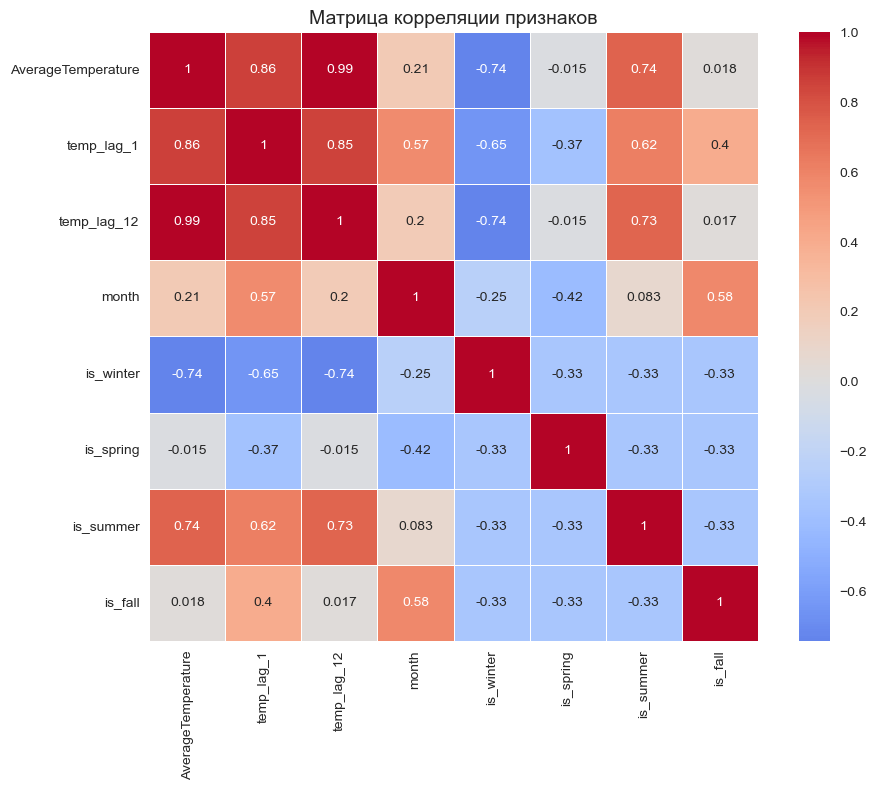

Наиболее сильные корреляции:
Температура и lag_1: 0.861
Температура и lag_12: 0.987


In [54]:
# Корреляция между признаками
import seaborn as sns

corr_features = ['AverageTemperature', 'temp_lag_1', 'temp_lag_12', 'month', 'is_winter', 'is_spring', 'is_summer', 'is_fall']
correlation_matrix = features_df_clean[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляции признаков', fontsize=14)
plt.tight_layout()
plt.show()

print("Наиболее сильные корреляции:")
print(f"Температура и lag_1: {correlation_matrix.loc['AverageTemperature', 'temp_lag_1']:.3f}")
print(f"Температура и lag_12: {correlation_matrix.loc['AverageTemperature', 'temp_lag_12']:.3f}")

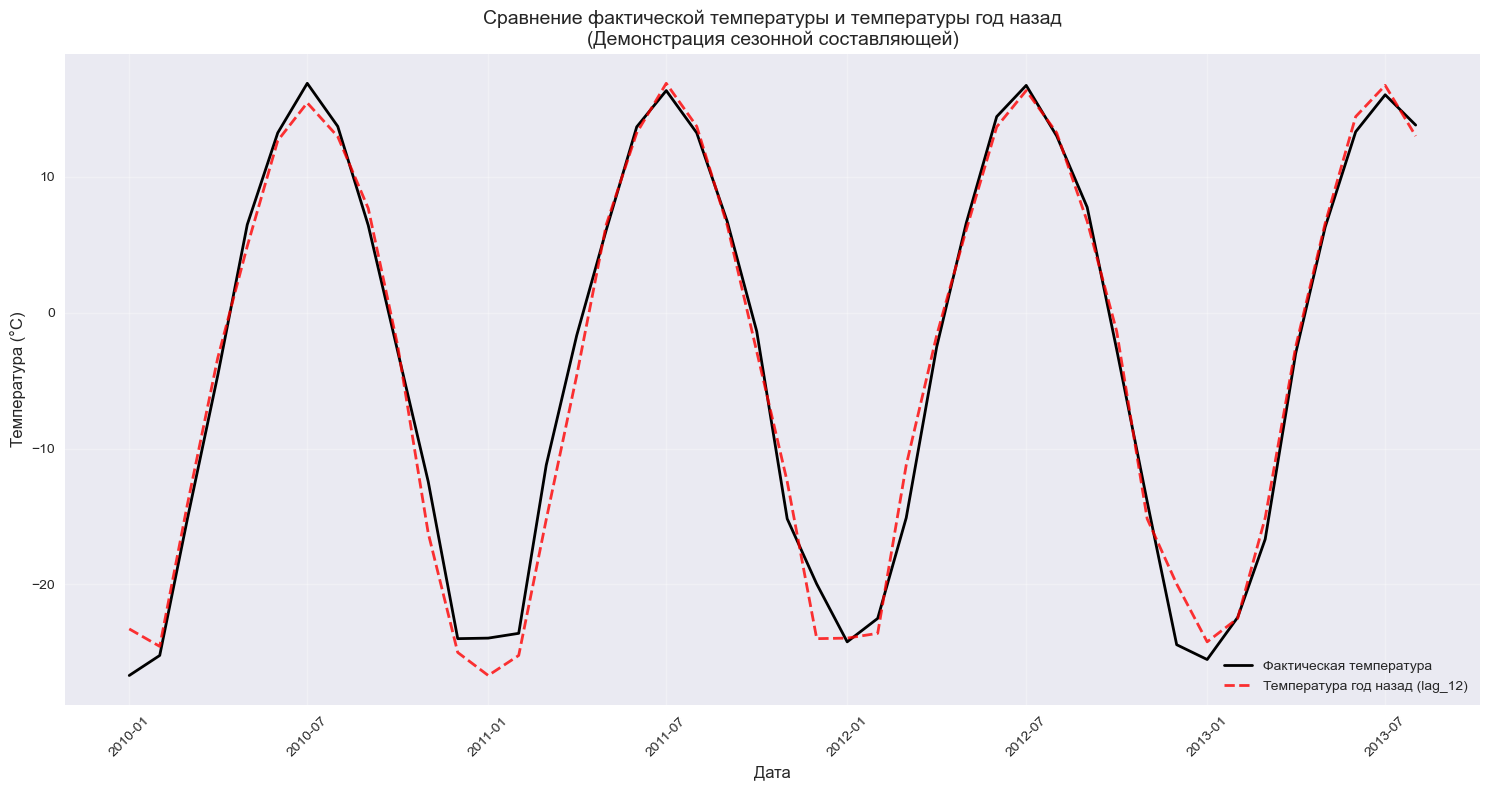

In [60]:
plt.figure(figsize=(15, 8))

sample_years = features_df_clean['2010-01-01':'2013-12-01']

plt.plot(sample_years.index, sample_years['AverageTemperature'], 
         label='Фактическая температура', linewidth=2, color='black')
plt.plot(sample_years.index, sample_years['temp_lag_12'], 
         label='Температура год назад (lag_12)', linewidth=2, linestyle='--', color='red', alpha=0.8)

plt.title('Сравнение фактической температуры и температуры год назад\n(Демонстрация сезонной составляющей)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Температура (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Корреляции всех признаков с целевой переменной (AverageTemperature):
temp_lag_12    : 0.987
temp_lag_1     : 0.861
is_summer      : 0.737
month          : 0.205
is_fall        : 0.018
is_spring      : -0.015
is_winter      : -0.740


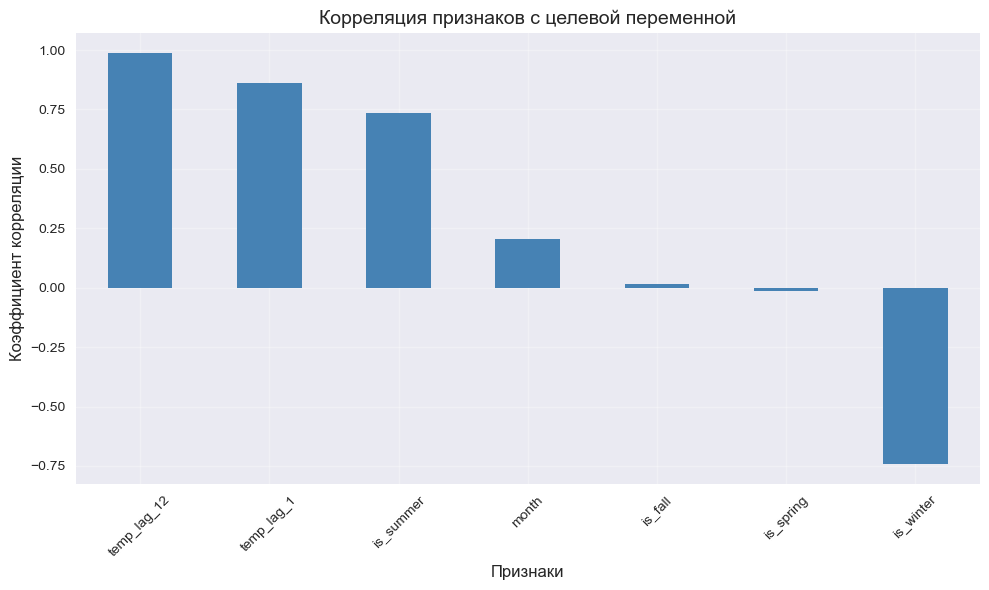

In [61]:
correlations = features_df_clean[corr_features].corr()['AverageTemperature'].sort_values(ascending=False)

print("Корреляции всех признаков с целевой переменной (AverageTemperature):")
for feature, corr in correlations.items():
    if feature != 'AverageTemperature':
        print(f"{feature:15}: {corr:.3f}")

plt.figure(figsize=(10, 6))
correlations.drop('AverageTemperature').plot(kind='bar', color='steelblue')
plt.title('Корреляция признаков с целевой переменной', fontsize=14)
plt.xlabel('Признаки', fontsize=12)
plt.ylabel('Коэффициент корреляции', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Выводы:

1. Сезонность - главный фактор: Корреляция 0.987 с lag_12 показывает, что температура имеет очень сильную годовую сезонность.
2. Инерционность температуры: Корреляция 0.861 с lag_1 указывает на то, что температура меняется постепенно от месяца к месяцу.
3. Хорошие перспективы для модели: Такие высокие корреляции с лагами означают, что даже простая модель должна давать хорошие результаты.
4. Календарные признаки могут быть менее важны: Поскольку лаги уже capture сезонность, календарные признаки (месяц, сезоны) могут иметь меньшую дополнительную ценность, но все равно полезны для модели.

## Шаг 5. Простая модель

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [63]:
model_df = features_df_clean.copy()

In [64]:
feature_columns = ['temp_lag_1', 'temp_lag_12', 'month', 'is_winter', 'is_spring', 'is_summer', 'is_fall']
target_column = 'AverageTemperature'

print("Признаки для модели:")
for feature in feature_columns:
    print(f"- {feature}")

Признаки для модели:
- temp_lag_1
- temp_lag_12
- month
- is_winter
- is_spring
- is_summer
- is_fall


### Этап 5.1 обучение

In [65]:
train_mask = model_df.index.isin(train_data.index)
test_mask = model_df.index.isin(test_data.index)

X_train = model_df[train_mask][feature_columns]
y_train = model_df[train_mask][target_column]
X_test = model_df[test_mask][feature_columns]
y_test = model_df[test_mask][target_column]

print(f"Размеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Размеры выборок:
X_train: (1909, 7), y_train: (1909,)
X_test: (484, 7), y_test: (484,)


In [66]:
model = LinearRegression()
model.fit(X_train, y_train)

print(f"\nМодель обучена!")
print(f"Коэффициенты модели: {model.coef_}")
print(f"Свободный член: {model.intercept_:.4f}")


Модель обучена!
Коэффициенты модели: [ 0.38157722  0.62210304 -0.31388414 -1.33266149  2.60437353  1.29093895
 -2.56265099]
Свободный член: 2.1156


In [67]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Важность признаков (по абсолютным значениям коэффициентов):")
print(feature_importance)

Важность признаков (по абсолютным значениям коэффициентов):
       feature  coefficient  abs_coefficient
4    is_spring     2.604374         2.604374
6      is_fall    -2.562651         2.562651
3    is_winter    -1.332661         1.332661
5    is_summer     1.290939         1.290939
1  temp_lag_12     0.622103         0.622103
0   temp_lag_1     0.381577         0.381577
2        month    -0.313884         0.313884


### Этап 5.2 Прогноз на тестовой выборке

In [68]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Date': y_test.index
}).set_index('Date')

results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df['Absolute_Error'] = np.abs(results_df['Error'])

print("Первые 10 прогнозов на тестовой выборке:")
results_df.head(10)

Первые 10 прогнозов на тестовой выборке:


,Actual,Predicted,Error,Absolute_Error
Date,,,,
1973-05-01,4.416,3.202045,1.213955,1.213955
1973-06-01,12.347,10.277884,2.069116,2.069116
1973-07-01,14.895,15.216174,-0.321174,0.321174
1973-08-01,12.736,14.405141,-1.669141,1.669141
1973-09-01,5.544,4.641067,0.902933,0.902933
1973-10-01,-4.955,-3.997384,-0.957616,0.957616
1973-11-01,-14.956,-17.301238,2.345238,2.345238
1973-12-01,-21.474,-22.299017,0.825017,0.825017
1974-01-01,-27.136,-23.873459,-3.262541,3.262541


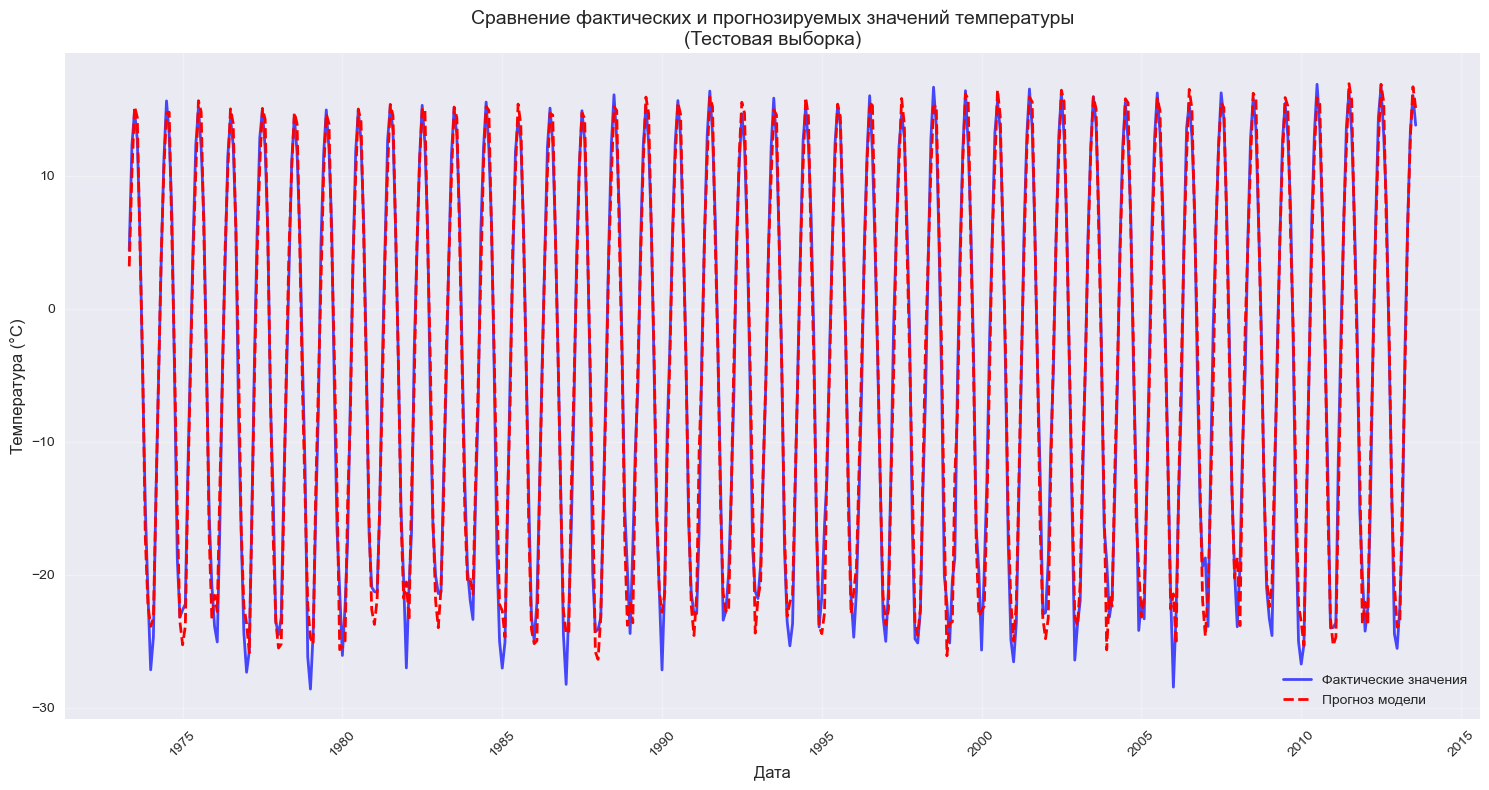

In [69]:
plt.figure(figsize=(15, 8))

plt.plot(results_df.index, results_df['Actual'], 
         label='Фактические значения', linewidth=2, color='blue', alpha=0.7)

plt.plot(results_df.index, results_df['Predicted'], 
         label='Прогноз модели', linewidth=2, color='red', linestyle='--')

plt.title('Сравнение фактических и прогнозируемых значений температуры\n(Тестовая выборка)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Температура (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [71]:
print("Проверка отсутствия утечек данных:")
print(f"Обучающая выборка охватывает период: {X_train.index[0].strftime('%Y-%m')} - {X_train.index[-1].strftime('%Y-%m')}")
print(f"Тестовая выборка охватывает период: {X_test.index[0].strftime('%Y-%m')} - {X_test.index[-1].strftime('%Y-%m')}")

train_test_overlap = X_train.index.isin(X_test.index).any()
print(f"Перекрытие между train и test: {train_test_overlap}")

Проверка отсутствия утечек данных:
Обучающая выборка охватывает период: 1813-01 - 1973-04
Тестовая выборка охватывает период: 1973-05 - 2013-08
Перекрытие между train и test: False


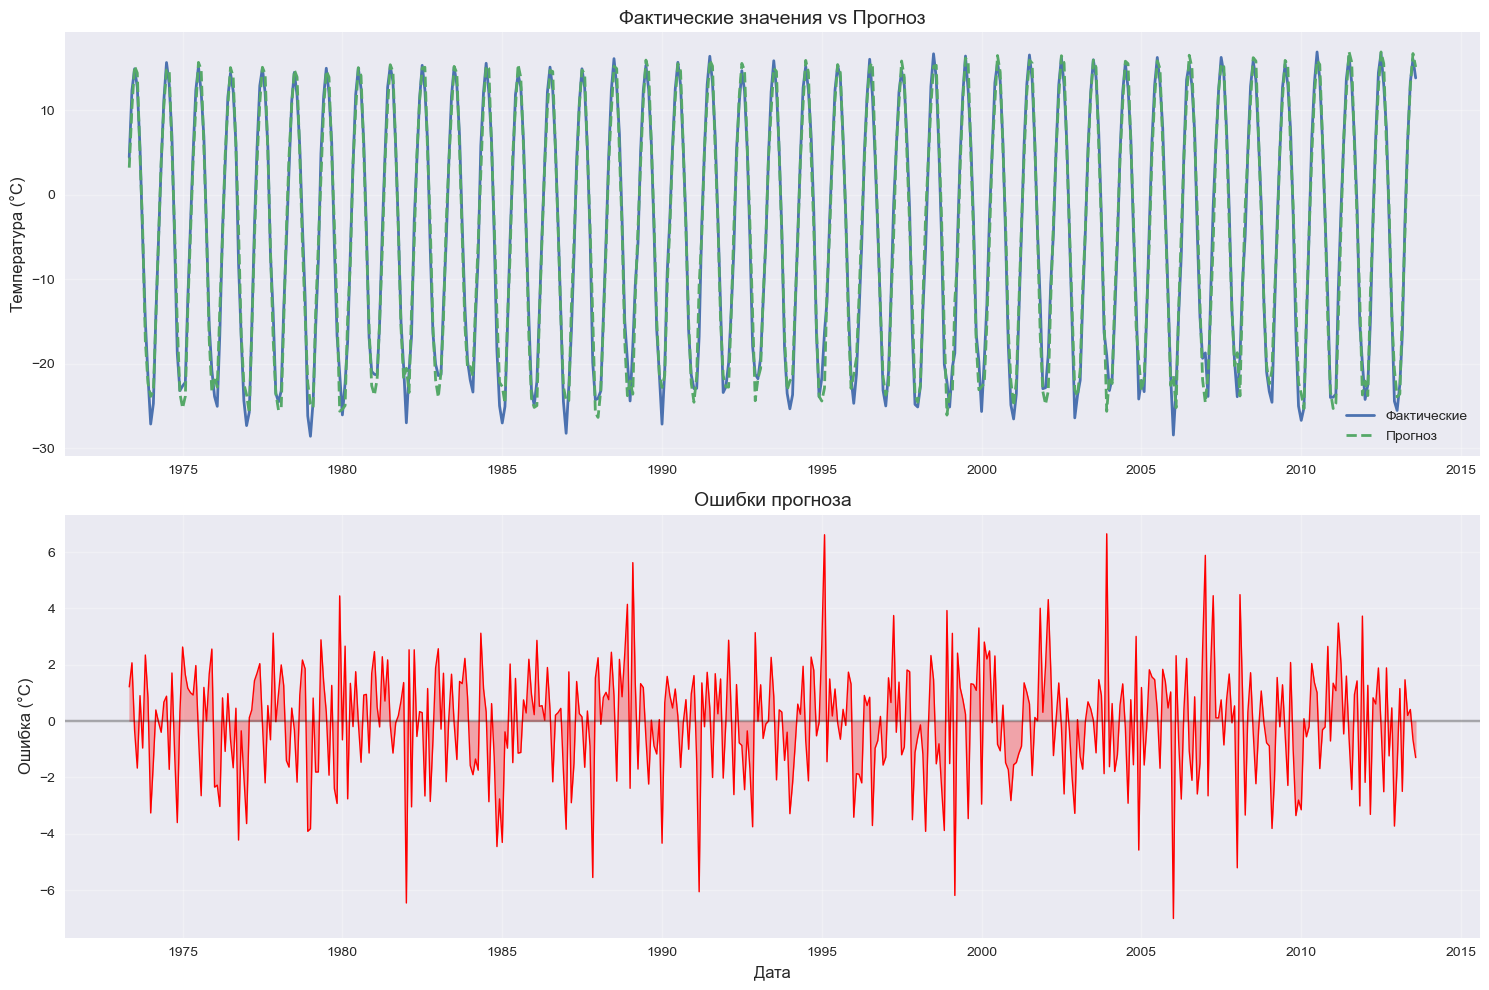

In [72]:
# Дополнительная визуализация: ошибки прогноза во времени
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(results_df.index, results_df['Actual'], label='Фактические', linewidth=2)
plt.plot(results_df.index, results_df['Predicted'], label='Прогноз', linewidth=2, linestyle='--')
plt.title('Фактические значения vs Прогноз', fontsize=14)
plt.ylabel('Температура (°C)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(results_df.index, results_df['Error'], color='red', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(results_df.index, results_df['Error'], 0, alpha=0.3, color='red')
plt.title('Ошибки прогноза', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Ошибка (°C)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Шаг 6. Метрики и оценки качества

### Этап 6.1 MAE, RMSE, MAPE

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [74]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("МЕТРИКИ КАЧЕСТВА ПРОГНОЗА")
print("=" * 50)
print(f"MAE (Средняя абсолютная ошибка):  {mae:.3f} °C")
print(f"RMSE (Среднеквадратичная ошибка): {rmse:.3f} °C")
print(f"MAPE (Средняя абсолютная ошибка в процентах): {mape:.2f} %")

МЕТРИКИ КАЧЕСТВА ПРОГНОЗА
MAE (Средняя абсолютная ошибка):  1.550 °C
RMSE (Среднеквадратичная ошибка): 1.983 °C
MAPE (Средняя абсолютная ошибка в процентах): 16.73 %


In [75]:
results_df['Month'] = results_df.index.month
monthly_errors = results_df.groupby('Month').agg({
    'Absolute_Error': 'mean',
    'Error': ['mean', 'std']
}).round(3)

monthly_errors.columns = ['MAE', 'Bias', 'Std_Error']
monthly_errors.index.name = 'Месяц'

print("\nСредние ошибки прогноза по месяцам:")
print(monthly_errors)


Средние ошибки прогноза по месяцам:
         MAE   Bias  Std_Error
Месяц                         
1      2.470 -1.173      2.790
2      1.938  0.799      2.323
3      1.722 -0.696      2.092
4      1.674  0.234      1.973
5      0.814  0.473      1.003
6      1.378  1.341      0.724
7      0.522 -0.029      0.640
8      1.951 -1.951      0.679
9      0.938  0.796      0.806
10     1.185 -0.245      1.469
11     1.991 -0.387      2.397
12     2.061  0.344      2.569


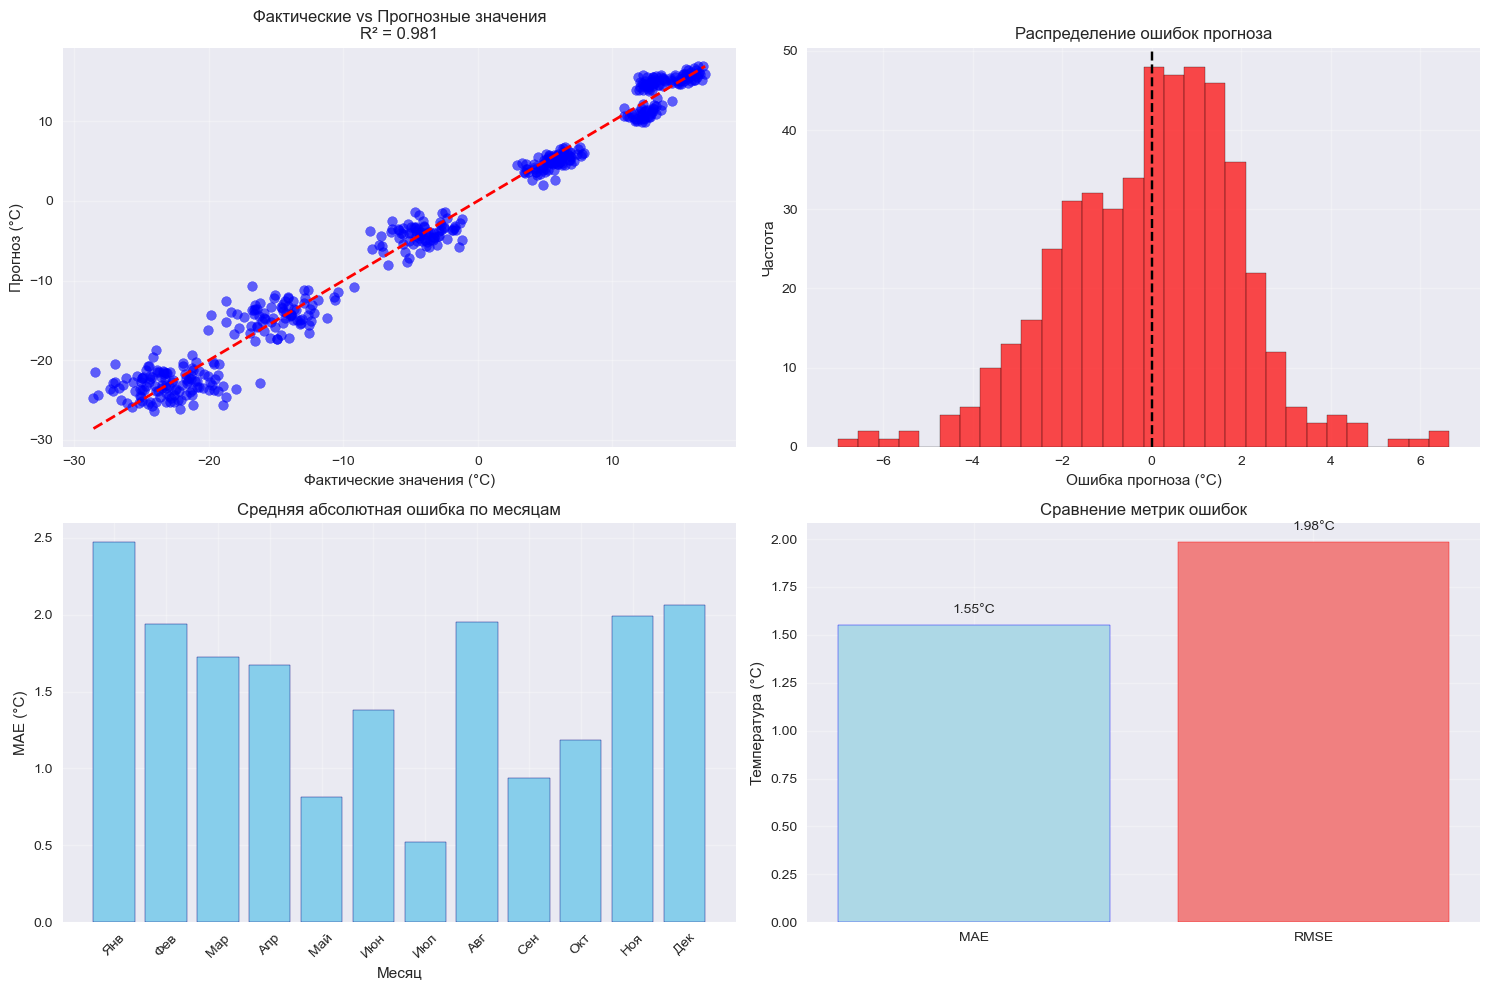

In [76]:
# Визуализация метрик и ошибок
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(y_test, y_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Фактические значения (°C)')
axes[0, 0].set_ylabel('Прогноз (°C)')
axes[0, 0].set_title(f'Фактические vs Прогнозные значения\nR² = {model.score(X_test, y_test):.3f}')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(results_df['Error'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0, 1].axvline(x=0, color='black', linestyle='--')
axes[0, 1].set_xlabel('Ошибка прогноза (°C)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок прогноза')
axes[0, 1].grid(True, alpha=0.3)

months = range(1, 13)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
               'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
monthly_mae = [monthly_errors.loc[i, 'MAE'] for i in months]

axes[1, 0].bar(month_names, monthly_mae, color='skyblue', edgecolor='navy')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('MAE (°C)')
axes[1, 0].set_title('Средняя абсолютная ошибка по месяцам')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

metrics = ['MAE', 'RMSE']
values = [mae, rmse]
colors = ['lightblue', 'lightcoral']

axes[1, 1].bar(metrics, values, color=colors, edgecolor=['blue', 'red'])
axes[1, 1].set_ylabel('Температура (°C)')
axes[1, 1].set_title('Сравнение метрик ошибок')
for i, v in enumerate(values):
    axes[1, 1].text(i, v + 0.05, f'{v:.2f}°C', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [77]:
temp_range = y_test.max() - y_test.min()
print("\nКОНТЕКСТ ТОЧНОСТИ ПРОГНОЗА:")
print("=" * 40)
print(f"Диапазон температур в тестовой выборке: {y_test.min():.1f}°C - {y_test.max():.1f}°C")
print(f"Общий диапазон: {temp_range:.1f}°C")
print(f"MAE составляет {mae/temp_range*100:.1f}% от общего диапазона температур")
print(f"Стандартное отклонение температур: {y_test.std():.2f}°C")
print(f"RMSE составляет {rmse/y_test.std()*100:.1f}% от стандартного отклонения")


КОНТЕКСТ ТОЧНОСТИ ПРОГНОЗА:
Диапазон температур в тестовой выборке: -28.6°C - 16.9°C
Общий диапазон: 45.5°C
MAE составляет 3.4% от общего диапазона температур
Стандартное отклонение температур: 14.38°C
RMSE составляет 13.8% от стандартного отклонения


### Этап 6.2 Выводы

## Итоговая оценка качества прогноза

### Рассчитанные метрики:
- **MAE (Средняя абсолютная ошибка)**: 1.550 °C
- **RMSE (Среднеквадратичная ошибка)**: 1.983 °C  
- **MAPE (Средняя абсолютная процентная ошибка)**: 16.73 %

### Интерпретация:
Модель демонстрирует умеренную точность прогнозирования температур со средней ошибкой 1.55°C (16.73%). Точность можно считать удовлетворительной, учитывая широкий диапазон температур в тестовой выборке (-28.6°C до 16.9°C, общий разброс 45.5°C).

### Анализ ошибок по месяцам:
- **Наибольшие ошибки** наблюдаются в зимние месяцы: январь (MAE=2.47°C), декабрь (MAE=2.06°C), февраль (MAE=1.94°C)
- **Наименьшие ошибки** - в летние месяцы: июль (MAE=0.52°C), май (MAE=0.81°C), сентябрь (MAE=0.94°C)
- В августе наблюдается систематическое занижение прогноза (Bias=-1.95°C), а в июне - завышение (Bias=1.34°C)

### Основные выводы:
1. Модель хорошо справляется с прогнозированием в теплые сезоны, но испытывает трудности с зимними температурами
2. Систематические ошибки в августе и июне указывают на возможность улучшения модели за счет учета дополнительных факторов
3. Несмотря на умеренную точность (MAPE=16.73%), модель адекватно улавливает сезонные закономерности
4. Для повышения точности, особенно в зимний период,可以考虑 использовать более сложные модели или дополнительные климатические признаки

Модель можно считать работоспособной для базового прогнозирования температур, но есть потенциал для улучшения, особенно в экстремальных температурных условиях.